In [17]:
import pandas_datareader as pdr
import datetime as dt
import matplotlib.pyplot as plt
import yfinance as yf, pandas as pd, shutil, os, time, glob
from get_all_tickers import get_tickers as gt
from pathlib import Path

In [4]:
# If you have a list of your own you would like to use just create a new list instead of using this, for example: tickers = ["FB", "AMZN", ...] 
tickers = gt.get_tickers_filtered(mktcap_min=150000, mktcap_max=3000000)
# Check that the amount of tickers isn't more than 2000
print("The amount of stocks chosen to observe: " + str(len(tickers)))

The amount of stocks chosen to observe: 59


In [5]:
# These two lines remove the Stocks folder and then recreate it in order to remove old stocks. Make sure you have created a Stocks Folder the first time you run this.
shutil.rmtree("SMA_Analysis/Stocks/")
os.mkdir("SMA_Analysis/Stocks/")

In [6]:
# Holds the amount of API calls we executed
Amount_of_API_Calls = 0
# This while loop is reponsible for storing the historical data for each ticker in our list. Note that yahoo finance sometimes incurs json.decode errors and because of this we are sleeping for 2
# seconds after each iteration, also if a call fails we are going to try to execute it again.
# Also, do not make more than 2,000 calls per hour or 48,000 calls per day or Yahoo Finance may block your IP. The clause "(Amount_of_API_Calls < 1800)" below will stop the loop from making
# too many calls to the yfinance API.
# Prepare for this loop to take some time. It is pausing for 2 seconds after importing each stock.

# Used to make sure we don't waste too many API calls on one Stock ticker that could be having issues
Stock_Failure = 0
Stocks_Not_Imported = 0

# Used to iterate through our list of tickers
i=0
while (i < len(tickers)) and (Amount_of_API_Calls < 10):
    try:
        print("Iteration = " + str(i))
        stock = tickers[i]  # Gets the current stock ticker
        temp = yf.Ticker(str(stock))
        Hist_data = temp.history(period="5y")  # Tells yfinance what kind of data we want about this stock (In this example, all of the historical data)
        Hist_data.to_csv("SMA_Analysis/Stocks/"+stock+".csv")  # Saves the historical data in csv format for further processing later
        time.sleep(2)  # Pauses the loop for two seconds so we don't cause issues with Yahoo Finance's backend operations
        Amount_of_API_Calls += 1 
        Stock_Failure = 0
        i += 1  # Iteration to the next ticker
    except ValueError:
        print("Yahoo Finance Backend Error, Attempting to Fix")  # An error occured on Yahoo Finance's backend. We will attempt to retreive the data again
        if Stock_Failure > 5:  # Move on to the next ticker if the current ticker fails more than 5 times
            i+=1
            Stocks_Not_Imported += 1
        Amount_of_API_Calls += 1
        Stock_Failure += 1
    # Handle SSL error
    except requests.exceptions.SSLError as e:
        print("Yahoo Finance Backend Error, Attempting to Fix SSL")  # An error occured on Yahoo Finance's backend. We will attempt to retreive the data again
        if Stock_Failure > 5:  # Move on to the next ticker if the current ticker fails more than 5 times
            i+=1
            Stocks_Not_Imported += 1
        Amount_of_API_Calls += 1
        Stock_Failure += 1
print("The amount of stocks we successfully imported: " + str(i - Stocks_Not_Imported))

Iteration = 0
Iteration = 1
Iteration = 2
Iteration = 3
Iteration = 4
Iteration = 5
Iteration = 6
Iteration = 7
Iteration = 8
Iteration = 9
The amount of stocks we successfully imported: 10


In [15]:
list_files = (glob.iglob("SMA_Analysis/Stocks/*.csv"))

for item in list_files:
    ticker = list_files["Close"]
    delta = ticker['Close'].diff()
    up = delta.clip(lower=0)
    down = -1*delta.clip(upper=0)
    ema_up = up.ewm(com=13, adjust=False).mean()
    ema_down = down.ewm(com=13, adjust=False).mean()
    rs = ema_up/ema_down

    ticker['RSI'] = 100 - (100/(1 + rs))
    print(item)
# # Skip first 14 days to have real values
list_files

TypeError: 'generator' object is not subscriptable

In [ ]:
fig, (ax1, ax2) = plt.subplots(2)
ax1.get_xaxis().set_visible(False)
fig.suptitle('ABBV')

ticker['Close'].plot(ax=ax1)
ax1.set_ylabel('Price ($)')
ticker['RSI'].plot(ax=ax2)
ax2.set_ylim(0,100)
ax2.axhline(30, color='r', linestyle='--')
ax2.axhline(70, color='r', linestyle='--')
ax2.set_ylabel('RSI')

plt.show()

In [19]:
ticker = pdr.get_data_yahoo("ABT", dt.datetime(2020,1,1), dt.datetime.now())

delta = ticker['Close'].diff()
up = delta.clip(lower=0)
down = -1*delta.clip(upper=0)
ema_up = up.ewm(com=13, adjust=False).mean()
ema_down = down.ewm(com=13, adjust=False).mean()
rs = ema_up/ema_down

ticker['RSI'] = 100 - (100/(1 + rs))

# Skip first 14 days to have real values
ticker = ticker.iloc[14:]

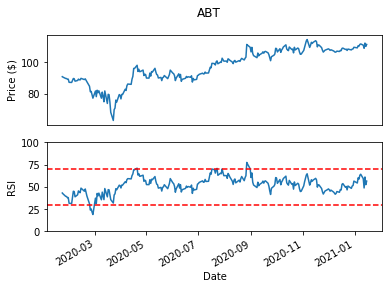

In [20]:
fig, (ax1, ax2) = plt.subplots(2)
ax1.get_xaxis().set_visible(False)
fig.suptitle('ABT')

ticker['Close'].plot(ax=ax1)
ax1.set_ylabel('Price ($)')
ticker['RSI'].plot(ax=ax2)
ax2.set_ylim(0,100)
ax2.axhline(30, color='r', linestyle='--')
ax2.axhline(70, color='r', linestyle='--')
ax2.set_ylabel('RSI')

plt.show()